In [ ]:
import tensorflow as tf
print(tf.__version__)

2.4.0


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [ ]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/Sunspots.csv \
    -O /tmp/sunspots.csv

--2021-01-26 02:58:06--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/Sunspots.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.193.128, 172.217.204.128, 172.217.203.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.193.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 70827 (69K) [application/octet-stream]
Saving to: ‘/tmp/sunspots.csv’

/tmp/sunspots.csv   100%[===================>]  69.17K  --.-KB/s    in 0.001s  

2021-01-26 02:58:07 (95.6 MB/s) - ‘/tmp/sunspots.csv’ saved [70827/70827]



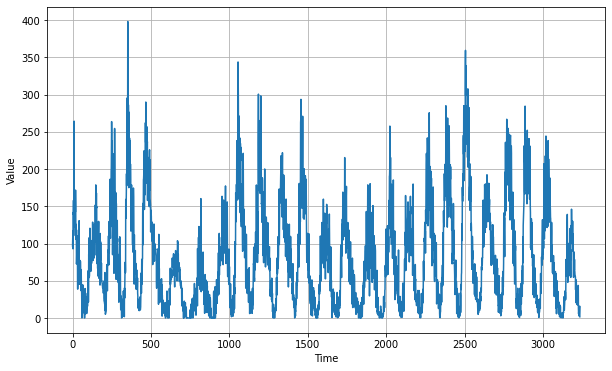

In [ ]:
import csv
time_step = []
sunspots = []

with open('/tmp/sunspots.csv') as csvfile:
  reader = csv.reader(csvfile, delimiter=',')
  next(reader)
  for row in reader:
    sunspots.append(float(row[2]))
    time_step.append(int(row[0]))

series = np.array(sunspots)
time = np.array(time_step)
plt.figure(figsize=(10,6))
plot_series(time, series)

In [ ]:
split_time = 3000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 60
batch_size = 32
shuffle_buffer_size = 1000

In [ ]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [ ]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(20, input_shape = [window_size], activation="relu"),
    tf.keras.layers.Dense(10, activation = "relu"),
    tf.keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=1e-7, momentum=0.9))
model.fit(dataset,epochs=100,verbose=0)

In [ ]:
forecast=[]

for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time+window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
# print(split_time-window_size)
# print(forecast)
results = np.array(forecast)[:, 0, 0]
# print(results)

2940
[array([[129.63106]], dtype=float32), array([[105.83427]], dtype=float32), array([[113.35545]], dtype=float32), array([[118.03028]], dtype=float32), array([[108.435745]], dtype=float32), array([[141.74326]], dtype=float32), array([[175.2191]], dtype=float32), array([[162.47603]], dtype=float32), array([[151.4627]], dtype=float32), array([[140.22282]], dtype=float32), array([[153.06284]], dtype=float32), array([[169.1961]], dtype=float32), array([[122.41629]], dtype=float32), array([[137.84683]], dtype=float32), array([[165.98769]], dtype=float32), array([[187.01224]], dtype=float32), array([[176.25255]], dtype=float32), array([[167.86142]], dtype=float32), array([[183.91937]], dtype=float32), array([[209.65985]], dtype=float32), array([[176.35336]], dtype=float32), array([[166.03542]], dtype=float32), array([[160.66692]], dtype=float32), array([[156.85472]], dtype=float32), array([[153.04842]], dtype=float32), array([[141.7314]], dtype=float32), array([[135.17426]], dtype=float32)

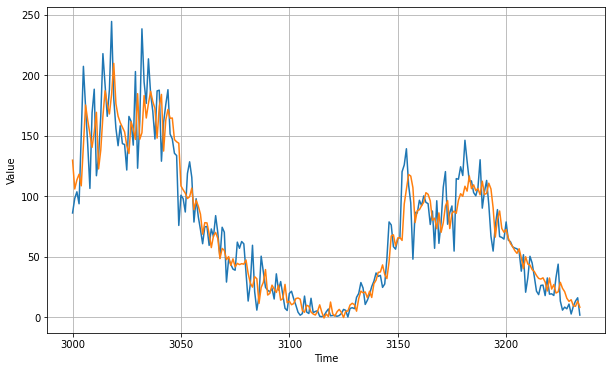

In [ ]:
plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [ ]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

14.349831